In [1]:
import torch
from torchinfo import summary
import torch.optim as optim
from torch.nn import MSELoss
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


from utils.metrics import validation_scores
from models.prediction.AE import AE
from utils.datasets import MNIST_SR
from utils.utils import gaussian_kl


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
num_epochs = 100
batch_size = 512
scalefactor = 4

path = f"trained_models/AE_MNIST_{scalefactor}x_prediction_mse.pth"

latent_dims = [64, 32, 64]
# condition_dims = [32, 64]
channels = [16, 32, 64, 128]
# cond_channels = [16, 32]
in_channels = 1
cond_base_width = 32 // scalefactor
model = AE(in_channels=in_channels,
                          latent_dims=latent_dims,
                          channels=channels,
                          base_width=cond_base_width
                          ).to(device)
print(model.sample(torch.randn(1, in_channels, cond_base_width, cond_base_width).to(device)).shape)
summary(model, input_size=[(1, in_channels, cond_base_width, cond_base_width)])

torch.Size([1, 1, 32, 32])


Layer (type:depth-idx)                   Output Shape              Param #
AE                                       [1, 1, 32, 32]            --
├─AELREncoder: 1-1                       [1, 64]                   --
│    └─Conv2d: 2-1                       [1, 16, 8, 8]             32
│    └─Conv2d: 2-2                       [1, 32, 4, 4]             8,224
│    └─Conv2d: 2-3                       [1, 64, 2, 2]             32,832
│    └─Linear: 2-4                       [1, 64]                   16,448
├─AEDecoder: 1-2                         [1, 1, 32, 32]            --
│    └─Linear: 2-5                       [1, 2048]                 133,120
│    └─ConvTranspose2d: 2-6              [1, 64, 8, 8]             131,136
│    └─ConvTranspose2d: 2-7              [1, 32, 16, 16]           32,800
│    └─ConvTranspose2d: 2-8              [1, 16, 32, 32]           8,208
│    └─Conv2d: 2-9                       [1, 1, 32, 32]            17
Total params: 362,817
Trainable params: 362,817
Non-train

In [3]:
train_dataset = MNIST_SR(scale_factor=scalefactor, split='train')
test_dataset = MNIST_SR(scale_factor=scalefactor, split='test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
num_train_data = len(train_dataset)
print(f"Dataset Loaded: {len(train_dataset)} training samples, {len(test_dataset)} validation samples")

Dataset Loaded: 60000 training samples, 10000 validation samples


In [4]:
# Adam opt
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = MSELoss()
# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

In [5]:
loss_list = []
recon_loss_list = []
kl_loss_list = []
val_loss_list = []
val_recon_loss_list = []
val_kl_loss_list = []

In [6]:
kl_weight = 1000

for epoch in range(num_epochs):
    model.train()
    
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0
    total_val_loss = 0
    total_val_recon_loss = 0
    total_val_kl_loss = 0

    for HR, LR in train_loader:
        optimizer.zero_grad()

        recon_imgs = model(LR)

        recon_loss = criterion(recon_imgs, HR)
        kl_loss = 0
        # for mu, logvar in latents:
        #     kl_loss += torch.mean(gaussian_kl(mu, logvar, torch.zeros_like(mu), torch.zeros_like(logvar)))
        loss = recon_loss + kl_weight * kl_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss#.item()

    scheduler.step()

    if (epoch) % 10 == 0 or epoch == num_epochs-1:
        model.eval()
        with torch.no_grad():
            for HR, LR in val_loader:
                recon_imgs = model(LR)
                recon_loss = criterion(recon_imgs, HR)
                kl_loss = 0
                # for mu, logvar in latents:
                #     kl_loss += torch.mean(gaussian_kl(mu, logvar, torch.zeros_like(mu), torch.zeros_like(logvar)))
                loss = recon_loss + kl_weight * kl_loss

                total_val_loss += loss.item()
                total_val_recon_loss += recon_loss.item()
                total_val_kl_loss += kl_loss#.item()

        total_val_loss /= len(val_loader)
        total_val_recon_loss /= len(val_loader)
        total_val_kl_loss /= len(val_loader)
        print(f"Validation Epoch [{epoch+1}/{num_epochs}] | Loss: {total_val_loss:.6f} | Recon Loss: {total_val_recon_loss:.6f} | KL Loss: {total_val_kl_loss:.6f}")
        val_loss_list.append(total_val_loss)
        val_recon_loss_list.append(total_val_recon_loss)
        val_kl_loss_list.append(total_val_kl_loss)
   

    total_loss /= len(train_loader)
    total_recon_loss /= len(train_loader)
    total_kl_loss /= len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {total_loss:.6f} | Recon Loss: {total_recon_loss:.6f} | KL Loss: {total_kl_loss:.6f}")
    loss_list.append(total_loss)
    recon_loss_list.append(total_recon_loss)
    kl_loss_list.append(total_kl_loss)

Validation Epoch [1/100] | Loss: 0.066202 | Recon Loss: 0.066202 | KL Loss: 0.000000
Epoch [1/100] | Loss: 0.083230 | Recon Loss: 0.083230 | KL Loss: 0.000000
Epoch [2/100] | Loss: 0.062646 | Recon Loss: 0.062646 | KL Loss: 0.000000
Epoch [3/100] | Loss: 0.047995 | Recon Loss: 0.047995 | KL Loss: 0.000000
Epoch [4/100] | Loss: 0.029645 | Recon Loss: 0.029645 | KL Loss: 0.000000
Epoch [5/100] | Loss: 0.017095 | Recon Loss: 0.017095 | KL Loss: 0.000000
Epoch [6/100] | Loss: 0.011747 | Recon Loss: 0.011747 | KL Loss: 0.000000
Epoch [7/100] | Loss: 0.009177 | Recon Loss: 0.009177 | KL Loss: 0.000000
Epoch [8/100] | Loss: 0.007929 | Recon Loss: 0.007929 | KL Loss: 0.000000
Epoch [9/100] | Loss: 0.007021 | Recon Loss: 0.007021 | KL Loss: 0.000000
Epoch [10/100] | Loss: 0.006291 | Recon Loss: 0.006291 | KL Loss: 0.000000
Validation Epoch [11/100] | Loss: 0.005514 | Recon Loss: 0.005514 | KL Loss: 0.000000
Epoch [11/100] | Loss: 0.005784 | Recon Loss: 0.005784 | KL Loss: 0.000000
Epoch [12/100

In [7]:
torch.save(model.state_dict(), path)

In [8]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

[]

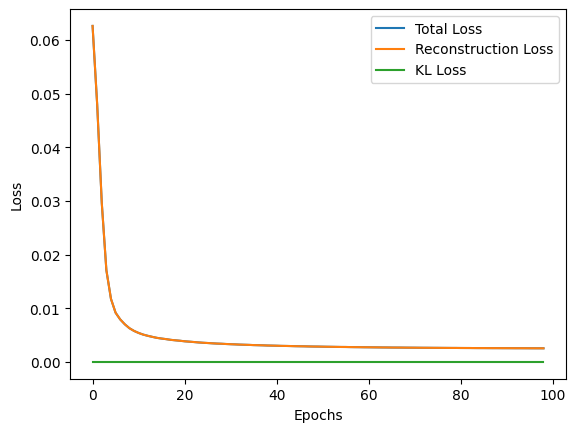

In [9]:
plt.plot(loss_list[1:], label='Total Loss')
plt.plot(recon_loss_list[1:], label='Reconstruction Loss')
plt.plot([l * kl_weight for l in kl_loss_list][1:], label='KL Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot()

In [10]:
HR, LR = test_dataset.get_samples(1000)
SR = model.sample(LR)

In [11]:
def show_image(x, low_res, superres, n):

    fig, axs = plt.subplots(3, n, figsize=(20, 6))
    for i in range(n):
        #figure description above every row in the middle
        if i == 0:
            axs[0, i].set_title('Original')
            axs[1, i].set_title('Low Resolution')
            axs[2, i].set_title('Super Resolution')

        axs[0, i].imshow(x[i].permute(1, 2, 0).detach().cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(low_res[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(superres[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[2, i].axis('off')

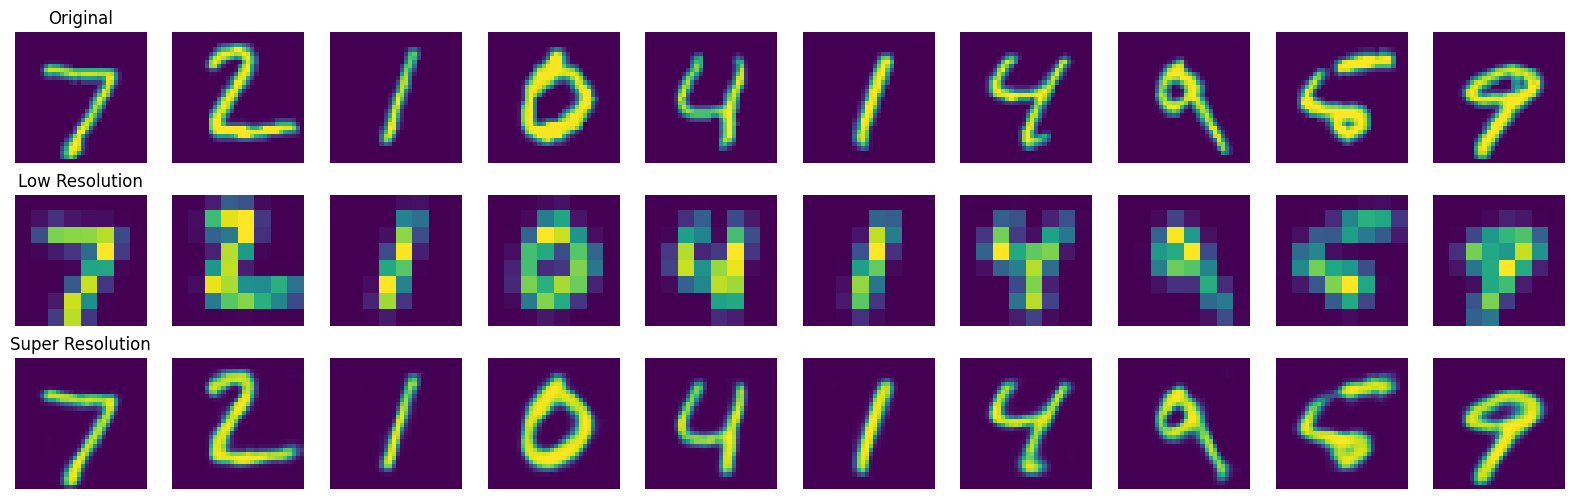

In [12]:
show_image(HR, LR, SR, 10)

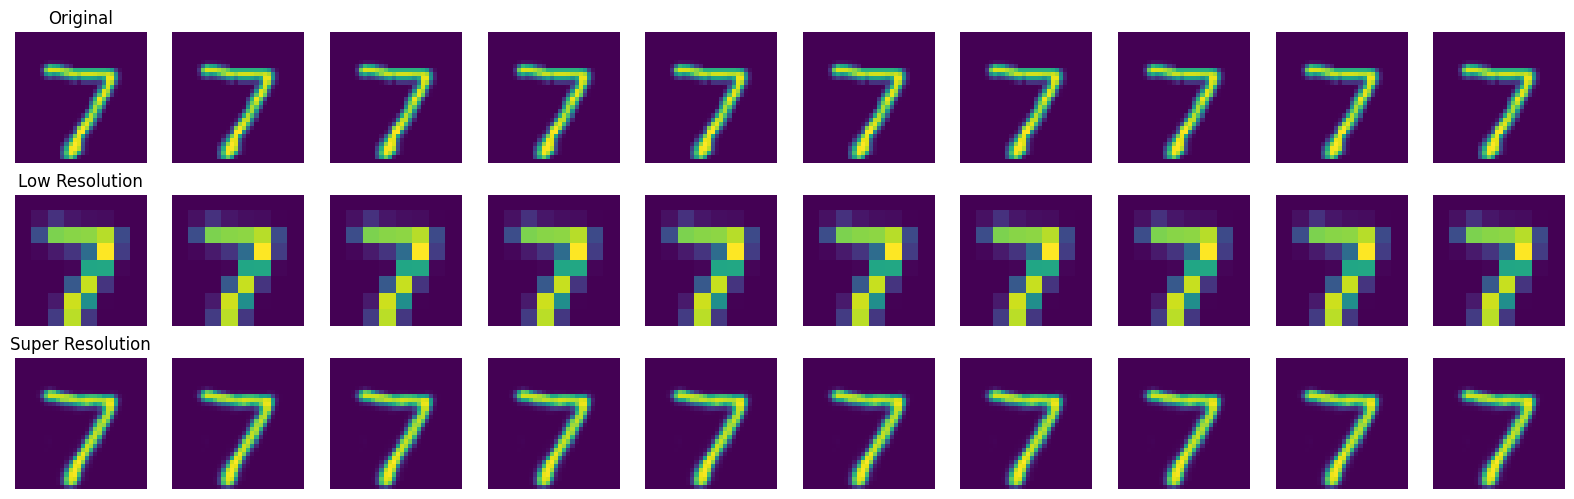

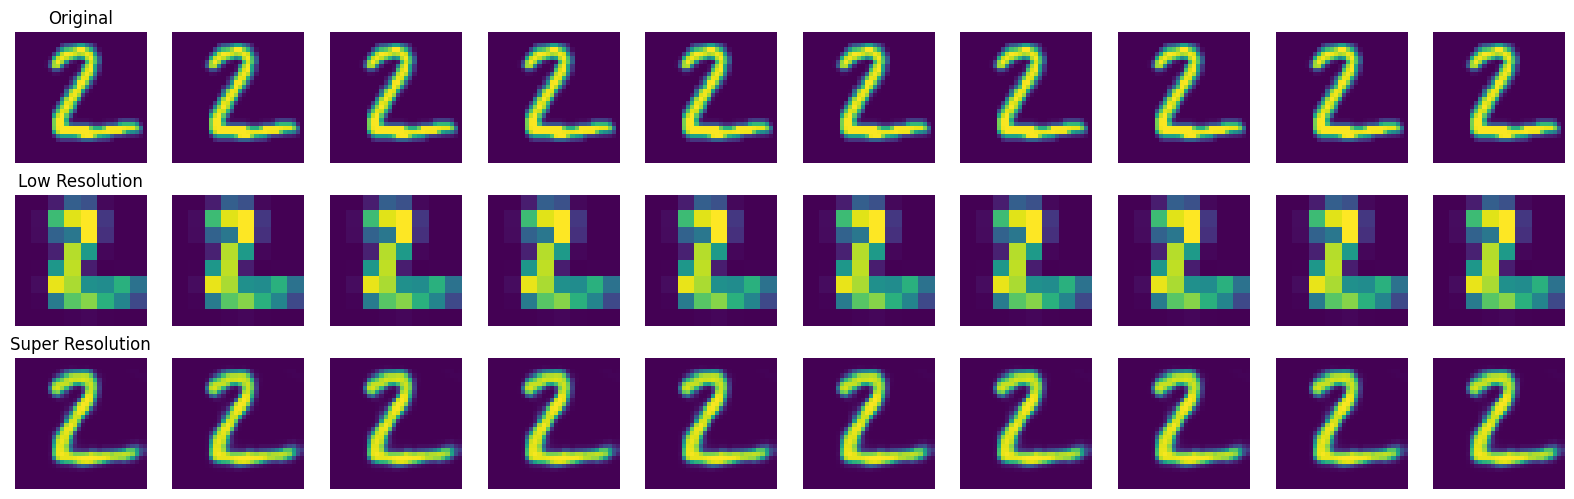

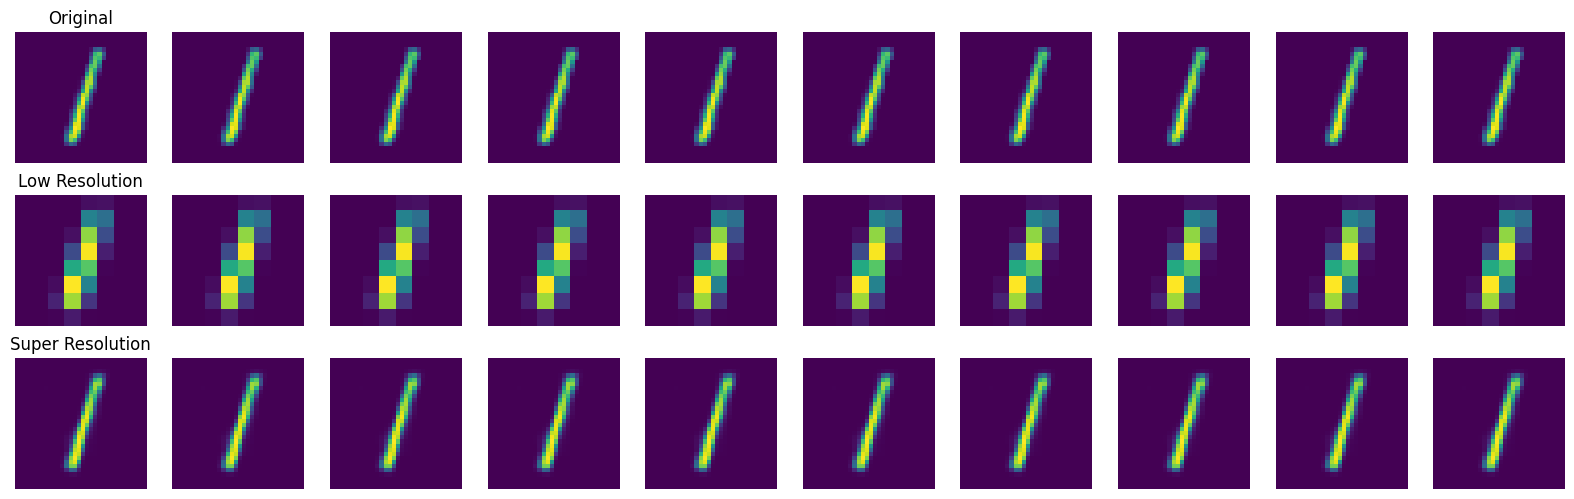

In [13]:
n_samp = 3

for i in range(n_samp):
    reference = HR[i]
    reference = reference.repeat(batch_size, 1, 1, 1)
    reference_inp = LR[i].unsqueeze(0).repeat(batch_size, 1, 1, 1)
    
    samples = model.sample(reference_inp).detach().cpu()

    show_image(reference, reference_inp, samples, 10)

In [14]:
mse_val, perceptual_val, psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(model, HR, LR)
print("MSE:", mse_val)
print("Perceptual:", perceptual_val)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val)
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\maxhe\anaconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MSE: 0.0026248819194734097
Perceptual: 0.6920102834701538
PSNR: 26.70466423034668
SSIM: 0.9597422480583191
LPIPS: 0.034813299775123596
BRISQUE: 72.70661926269531
PSNR Consistency: 41.33844757080078
MSE Diversity: 9.844594917727309e-17
LPIPS Diversity: 2.0184819469385343e-13
